In [1]:
import wave
import numpy as np
import torch
import os
import glob
from tqdm import tqdm
import sys
import pyaudio
import matplotlib.pyplot as plt

sys.path.append('../')
from src.models.encoder.cnn_ae import CNNAutoEncoder
from espnet2.bin.asr_parallel_transducer_inference import Speech2Text

In [2]:
from src.models.timing.model_baseline import BaselineSystem
from src.utils.utils import load_config

In [3]:
def asr_streaming_decoding(data, is_final=False):
    speech = data.astype(np.float16)/32767.0
    hyps = speech2text.streaming_decode(speech=speech, is_final=is_final)
    if hyps[2] is None:
        results = speech2text.hypotheses_to_results(speech2text.beam_search.sort_nbest(hyps[1]))
    else:
        results = speech2text.hypotheses_to_results(speech2text.beam_search.sort_nbest(hyps[2]))
        
    if results is not None and len(results) > 0 and len(results[0]) > 0:
        text = results[0][0]
        token_int = results[0][2]
    else:
        text = ''
        token_int = [0]
        
    if token_int == []:
        token_int = [0]
        
    return text, token_int

In [4]:
speech2text = Speech2Text(
    asr_base_path="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1",
    asr_train_config="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/config.yaml",
    asr_model_file="/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1/exp/asr_train_asr_cbs_transducer_848_finetune_raw_jp_char_sp/valid.loss_transducer.ave_10best.pth",
    token_type=None,
    bpemodel=None,
    beam_search_config={"search_type": "maes"},
    beam_size=3,
    lm_weight=0.0,
    nbest=1,
    #device = "cuda:0", # "cpu",
    device = "cpu",
)

3steps


In [5]:
cnnae = CNNAutoEncoder(device='cpu')

In [6]:
config_path = '../configs/timing/timing_baseline_mla_s1234.json'
config = load_config(config_path)

device = torch.device('cpu')

model = BaselineSystem(config, device)

In [7]:
path = "../exp/test/model_baseline_mla_s1234/cv1/best_val_loss_model.pth"

model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))#, strict=False)
model.to(device)

BaselineSystem(
  (timing_model): TimingEstimator(
    (lstm): LSTM(384, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=1, bias=True)
    (criterion): BCEWithLogitsLoss()
  )
  (feature_extractor): FeatureExtractor(
    (acoustic_encoder): AcousticEncoder(
      (lstm): LSTM(128, 512, batch_first=True)
      (fc): Linear(in_features=512, out_features=128, bias=True)
    )
    (timing_encoder): TimingEncoder(
      (vad): VAD(
        (lstm): LSTM(128, 512, batch_first=True)
        (fc): Linear(in_features=512, out_features=1, bias=True)
        (criterion): BCEWithLogitsLoss()
      )
      (linear): Linear(in_features=3, out_features=128, bias=True)
    )
    (semantic_encoder): TransformerEncoder(
      (transformer): TransformerModel(
        (pos_encoder): PositionalEncoding(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (transformer_encoder): TransformerEncoder(
          (layers): ModuleList(
            (0): TransformerEncoderLayer(

# File Input

In [13]:
# wav folder の指定
root = '/mnt/aoni04/jsakuma/data/ATR-Fujie'
names_dir = os.path.join(root, 'samples/wav')
names = sorted(os.listdir(names_dir))
# for i, name in enumerate(tqdm(names)):
i = 0
name = names[i]
turn_dir = os.path.join(names_dir, name)
turns = sorted(os.listdir(turn_dir))
# for j, turn in enumerate(turns):
j = 1
turn = turns[j]
wav_path = os.path.join(turn_dir, turn)
print(wav_path)

wf = wave.open(wav_path)
wav = np.frombuffer(wf.readframes(wf.getnframes()), np.int16)

/mnt/aoni04/jsakuma/data/ATR-Fujie/samples/wav/20131101-1_01/20131101-1_01_001_ch0.wav


In [18]:
import time
# start = time.perf_counter()

chunk_size = 800*2
#chunk_size = 2048
asr_chunk_size = 2048

cnnae.reset_generator()
speech2text.reset_inference_cache()
model.reset_state()

pred_list = []
text_list = []
silence_list = []
vad_list = []
text = ''
pre_text = ''
pre_id = [0]
asr_buffer = np.array([], dtype='int16')
with torch.no_grad():
    for i in range(len(wav)//chunk_size):
        
#         start_o = time.perf_counter()
        
#         start = time.perf_counter()
        wav_chunk = wav[chunk_size*i:chunk_size*(i+1)]

        # ASR : 
        asr_buffer = np.concatenate([asr_buffer, wav_chunk])
        if len(asr_buffer) >= asr_chunk_size:
            asr_chunk = asr_buffer[:asr_chunk_size]
            asr_buffer = asr_buffer[asr_chunk_size:]

            text, token_int = asr_streaming_decoding(asr_chunk)
        else:
            text = pre_text
            token_int = pre_id

        pre_text = text
        pre_id = token_int
        
#         end = time.perf_counter()        
#         print("ASR: {:.5f}".format(end-start))
#         start = time.perf_counter()
        
        # CNN-AE
        if i == 0:
            pad = np.zeros(1440, np.int16)
            wav_chunk = np.concatenate([pad, wav_chunk])
            
        feature, _ = cnnae(wav_chunk, streaming=True)    
        
#         end = time.perf_counter()        
#         print("Feature Extraction: {:.5f}".format(end-start))

        # Timing Estimator
        feat = torch.tensor(feature.reshape(1, 1, 128))
        input_lengths = [1]
        texts = [[text]]
        idxs = [[token_int]]
        indices = [None]

        batch = [feat, input_lengths, texts, idxs, indices, 'test']
        out, silence, vad_out = model.streaming_inference(batch, debug=True) 
        out = torch.sigmoid(out).item()

        pred_list.append(out)
        text_list.append(text)
        silence_list.append(silence)
        vad_list.append(vad_out.item())
        
#         end = time.perf_counter()        
#         print("Timing Estimator: {:.5f}".format(end-start))
        
#         end_o = time.perf_counter()        
#         print("Total: {:.5f}".format(end_o-start_o))
#         print()

In [19]:
vad_list

[0.33940473198890686,
 0.2755621075630188,
 0.15097029507160187,
 0.4937060475349426,
 0.5947045087814331,
 0.7498298287391663,
 0.9079759120941162,
 0.9087150692939758,
 0.48047691583633423,
 0.8406269550323486,
 0.8046835660934448,
 0.9297930598258972,
 0.6538931131362915,
 0.9044913053512573,
 0.8848777413368225,
 0.8940269351005554,
 0.9004455804824829,
 0.9167243242263794,
 0.8168574571609497,
 0.7736541628837585,
 0.926791250705719,
 0.8935041427612305,
 0.6952912211418152,
 0.7621296644210815,
 0.8279566168785095,
 0.8694313168525696,
 0.751674234867096,
 0.6414175033569336,
 0.9457836151123047,
 0.8677816987037659,
 0.9154453277587891,
 0.769135594367981,
 0.6072667241096497,
 0.6283039450645447,
 0.6786803603172302,
 0.8343160152435303,
 0.7122665643692017,
 0.3830651044845581,
 0.02996811270713806,
 0.013936136849224567,
 0.01632322184741497,
 0.01895466260612011,
 0.02989845536649227,
 0.18011946976184845,
 0.21081769466400146,
 0.028258642181754112,
 0.4802313446998596,
 0.

In [20]:
silence_list

[tensor([[[0.6606, 0.0000, 1.0000]]]),
 tensor([[[1.3850, 0.0000, 2.0000]]]),
 tensor([[[2.2341, 0.0000, 3.0000]]]),
 tensor([[[2.7404, 0.0000, 4.0000]]]),
 tensor([[[3.1457, 1.0000, 5.0000]]]),
 tensor([[[3.3958, 2.0000, 6.0000]]]),
 tensor([[[3.4878, 3.0000, 7.0000]]]),
 tensor([[[3.5791, 4.0000, 8.0000]]]),
 tensor([[[4.0987, 0.0000, 9.0000]]]),
 tensor([[[ 4.2580,  1.0000, 10.0000]]]),
 tensor([[[ 4.4533,  2.0000, 11.0000]]]),
 tensor([[[ 4.5236,  3.0000, 12.0000]]]),
 tensor([[[ 4.8697,  4.0000, 13.0000]]]),
 tensor([[[ 4.9652,  5.0000, 14.0000]]]),
 tensor([[[ 0.,  6., 15.]]]),
 tensor([[[ 0.1060,  7.0000, 16.0000]]]),
 tensor([[[ 0.2055,  8.0000, 17.0000]]]),
 tensor([[[ 0.2888,  9.0000, 18.0000]]]),
 tensor([[[ 0.4719, 10.0000, 19.0000]]]),
 tensor([[[ 0.6983, 11.0000, 20.0000]]]),
 tensor([[[ 0.7715, 12.0000, 21.0000]]]),
 tensor([[[ 0.8780, 13.0000, 22.0000]]]),
 tensor([[[ 1.1827, 14.0000, 23.0000]]]),
 tensor([[[ 1.4206, 15.0000, 24.0000]]]),
 tensor([[[ 1.5926, 16.0000, 25

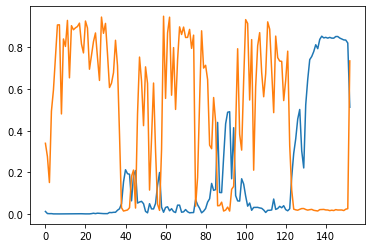

In [21]:
import matplotlib.pyplot as plt

plt.plot(pred_list)
plt.plot(vad_list)

In [19]:
text_list

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'あ',
 'あ',
 'あすい',
 'あすいませ',
 'あすいません',
 'あすいません',
 'あすいません今',
 'あすいません今',
 'あすいません今ー',
 'あすいません今あの',
 'あすいません今あの',
 'あすいません今あの',
 'あすいません今あの軒',
 'あすいません今あの秋',
 'あすいません今あの秋',
 'あすいません今あの秋葉',
 'あすいません今あの秋葉原',
 'あすいません今あの秋葉原に',
 'あすいません今あの秋葉原にー',
 'あすいません今あの秋葉原にー',
 'あすいません今あの秋葉原にーいる',
 'あすいません今あの秋葉原にーいる',
 'あすいません今あの秋葉原にーいるんで',
 'あすいません今あの秋葉原にーいるんです',
 'あすいません今あの秋葉原にーいるんです',
 'あすいません今あの秋葉原にーいるんですけ',
 'あすいません今あの秋葉原にーいるんですけど',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどー',
 'あすいません今あの秋葉原にーいるんですけどーこ',
 'あすいません今あの秋葉原にーいるんですけどーこれ',
 'あすいません今あの秋葉原にーいるんですけどーこれか',
 'あすいません今あの秋葉原にーいるんですけどーこれか',
 'あすいません今あの秋葉原にーいるんですけどーこれから',
 'あすいません今あの秋葉原にーいるんですけどーこれからー',
 'あすいません今あの秋葉原にーいるんですけどーこれからー',
 'あすいません今あの秋葉原にーいるんですけどーこれからーあの',
 'あすいません今あの秋葉原にーいるんですけどーこれからーあの',
 'あすいません今あの秋葉原にーいるんですけどーこれからーあのおせ',
 'あすいません今あの秋葉原にーいるんですけどーこれ

# Microphone Input

In [ ]:
CHUNK=1600
ASR_CHUNK=2048

FORMAT=pyaudio.paInt16
CHANNELS=1
RATE=16000
RECORD_SECONDS=7
p=pyaudio.PyAudio()
stream = p.open(format=FORMAT,channels=CHANNELS,rate=RATE,input=True,frames_per_buffer=CHUNK)

cnnae.reset_generator()
speech2text.reset_inference_cache()
model.reset_state()

pred_list = []
text_list = []
vad_list = []
frames = []
text = ''
pre_text = ''
pre_id = 0
asr_buffer = np.array([], dtype='int16')
for i in range(0,int(RATE/CHUNK*RECORD_SECONDS)+1):        

    data=stream.read(CHUNK)
    data=np.frombuffer(data, dtype='int16')
    frames.append(data)
    #data=data.astype(np.float16)/32767.0 #32767 is the upper limit of 16-bit binary numbers and is used for the normalization of int to float.

    with torch.no_grad():
        asr_buffer = np.concatenate([asr_buffer, data])
        if len(asr_buffer) >= ASR_CHUNK:
            asr_chunk = asr_buffer[:ASR_CHUNK]
            asr_buffer = asr_buffer[ASR_CHUNK:]

            text, token_int = asr_streaming_decoding(asr_chunk)
            progress_output(text)
        else:
            text = pre_text
            token_int = pre_id
            progress_output(text)
            
        pre_text = text
        pre_id = token_int

        # CNN-AE
        if i == 0:
            pad = np.zeros(1440, np.int16)
            data = np.concatenate([pad, data])

        feature, _ = cnnae(data, streaming=True)    

        # Timing Estimator
        feat = torch.tensor(feature.reshape(1, 1, 128))
        input_lengths = [1]
        texts = [[text]]
        idxs = [[token_int]] 
        indices = [None]

        batch = [feat, input_lengths, texts, idxs, indices, 'test']
        out, silence, vad_out = model.streaming_inference(batch, debug=True) 
        out = torch.sigmoid(out).item()
        out = torch.sigmoid(out).item()

        pred_list.append(out)
        text_list.append(text)
        vad_list.append(vad_out)
        
stream.stop_stream()
stream.close()
p.terminate()